In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.interpolate import interp1d, interp2d


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import pickle
import sys

python_source_code_path = "C://Users//yuan//PycharmProjects//High-T-Angstrom-Method"
# This is where you want to put the source code, change it to your local drive locaiton

sys.path.insert(1, python_source_code_path)

from high_T_angstrom_method import batch_process_horizontal_lines,simulation_result_amplitude_phase_extraction,interpolate_light_source_characteristic

In [2]:
# This is where you put your jupyter notebooks which runs the source code
code_directory = "G://My Drive//Current Projects//Angstrom Method//High Temperature Simulation//Jupyter Notebook//"

# We load the sample properties
df_sample_cp_rho_alpha_all = pd.read_excel(code_directory + "sample specifications//sample properties.xlsx",
                                           sheet_name="sample properties")

# This is the dataframe that correlate voltage signal to solar simulator total emission
df_solar_simulator_VQ = pd.read_csv(code_directory + "sample specifications//9_14_Amax_Fv_d_correlations.csv")

# This is the dataframe that describe the intensity distribution parameter sigma at different locations
sigma_df = pd.read_csv(code_directory + "sample specifications//Lorentzian sigma_Sept.csv")



focal_plane_location = 3 # how far is the sample relative to the focal plane
sample_name = 'copper' # Which sample you are simulating? Available options are defined in df_sample_cp_rho_alpha_all

df_sample_cp_rho_alpha = df_sample_cp_rho_alpha_all.query("sample_name=='{}'".format(sample_name)) # only choose one sample




"""
R: radius, in m
t_z: disk thickness, in m
rho: density, SI unit
cp = cp_const + cp_c1*T + cp_c2*T^2 + ..., T in unit K
alpha_r: radial thermal diffusivity: m2/s
alpha_z: axial thermal diffusivity: m2/s

"""


sample_information = {'sample_name':sample_name,'R':8.89/2/100,'t_z':1/32*2.5/100,'rho':float(df_sample_cp_rho_alpha['rho']),'cp_const':float(df_sample_cp_rho_alpha['cp_const']),'cp_c1':
                      float(df_sample_cp_rho_alpha['cp_c1']),'cp_c2':float(df_sample_cp_rho_alpha['cp_c2']),'cp_c3':float(df_sample_cp_rho_alpha['cp_c3']),
                      'alpha_r':float(df_sample_cp_rho_alpha['alpha_r']),'alpha_z':float(df_sample_cp_rho_alpha['alpha_z']),'T_initial':800+273.15,
                      'emissivity_front':0.90,'emissivity_back':0.90,'absorptivity_front':0.90,'absorptivity_back':0.90}


"""
N_Rs: number of pixels exposed to concentrated light
T_sur1: front side temperature, if light blocker is placed this is the light blocker temperature
T_sur2: backside temperature
RO: the very first radius used as reference location
R_analysis: the range used to evaluate properties, unit in pixel

"""

vacuum_chamber_setting = {'N_Rs':50,'T_sur1':1023,'T_sur2':523,'R0':55,'focal_shift':0,'R_analysis':36}


"""
Nr: total number of grid on the radius of the sample, this number equals to the experimentally measured number of pixels on the radius
N_cycle: maximum number of cycles for periodic heating
vectorize: with or without vectorize
Fo_criteria: stability criteria, can be reduced if non stable
frequency_analysis_method: how to extract amplitude and phase, sine: fit to sinusoidal function, fft: use fft, requires more cycle, more robust against noisy
gap: the distance between neighboring locations used to calculation amplitude and phase
view_factor_setting: when you do sensitivity analysis, set to False. If not sensitivity analysis, if no light blocker is in place (sigma measurement), set to False. Otherwise for measuring thermal diffusivity, set to True.
"""

numerical_simulation_setting = {'Nz':3,'Nr':200,'equal_grid':True,'N_cycle':20,'vectorize':True,'Fo_criteria':1/3,
                                'simulated_amp_phase_extraction_method':'sine','gap':4,'view_factor_setting':True,'regression_result_type':'alpha_r'}

solar_simulator_settings = {'f_heating':0.1,'V_amplitude':2,'V_DC':4,'rec_name':'2_level_DOE'}

focal_shift = vacuum_chamber_setting['focal_shift']



"""
q(r,V) = Amax*(bvd+kvd*V)/pi*(sigma_s/(sigma_s**2+r**2)) 
given control voltage V and radial location r, how to estimate light source heat flux

"""
Amax, sigma_s, kvd, bvd = interpolate_light_source_characteristic(sigma_df, df_solar_simulator_VQ, focal_shift)


light_source_property = {'Amax':Amax,'sigma_s':sigma_s,'kvd':kvd,'bvd':bvd}

In [3]:
df_amp_phase_simulated,df_temperature_simulation = simulation_result_amplitude_phase_extraction(sample_information, vacuum_chamber_setting, solar_simulator_settings,
                                                        light_source_property, numerical_simulation_setting,code_directory,df_solar_simulator_VQ,sigma_df)

C:\Users\yuan\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=6,8 m=21 fp=3.056017 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\yuan\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=6,8 m=21 fp=1.975072 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\yuan\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. 

stable temperature profile has been obtained @ iteration N= 8!
alpha_r = 9.00E-05, focal plane = 0 cm, sigma_s = 6.50E-03, f_heating = 0.1 Hz, Rec = 2_level_DOE, T_LB_mean = 1071.7 K, e_front = 0.90.


In [4]:
# The unit here is K, the simulation output the last two cycles once it consider steady state (temperature increase rate is less than 0.5% of oscillation amplitude) is reached.

# Also note the temperature at the start of the cycle may not be the same as the temperature at the end of the cycle. This is due to non-steady behavior, if you need more cycles, please artificially make them equal, then duplicate to get more cycles

df_temperature_simulation.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,reltime
0,1224.880776,1224.812333,1224.605585,1224.261667,1223.781942,1223.168238,1222.422846,1221.548488,1220.548282,1219.425701,...,989.706411,989.626595,989.554744,989.491030,989.435636,989.388759,989.350602,989.321379,989.301307,59.999634
1,1225.518954,1225.450281,1225.242846,1224.897786,1224.416467,1223.800726,1223.052858,1222.175596,1221.172068,1220.045756,...,989.663115,989.583262,989.511379,989.447638,989.392225,989.345333,989.307167,989.277941,989.257871,60.024514
2,1226.161839,1226.092937,1225.884814,1225.538610,1225.055696,1224.437913,1223.687566,1222.807395,1221.800539,1220.670491,...,989.620218,989.540325,989.468408,989.404640,989.349205,989.302298,989.264123,989.234892,989.214825,60.049395
3,1226.809268,1226.740136,1226.531324,1226.183974,1225.699463,1225.079637,1224.326807,1223.443724,1222.433535,1221.299746,...,989.577730,989.497795,989.425843,989.362046,989.306588,989.259664,989.221478,989.192244,989.172178,60.074275
4,1227.461074,1227.391712,1227.182210,1226.833714,1226.347604,1225.725732,1224.970418,1224.084419,1223.070893,1221.933360,...,989.535662,989.455682,989.383693,989.319865,989.264383,989.217442,989.179245,989.150006,989.129942,60.099155


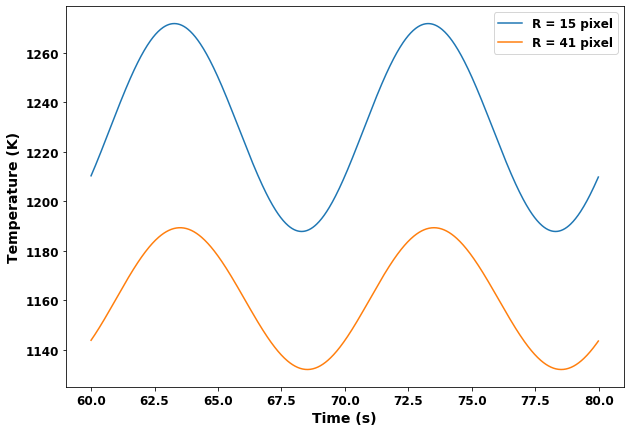

In [5]:
fig = plt.figure(figsize=(10, 7))

plt.plot(df_temperature_simulation['reltime'], df_temperature_simulation[15],label = 'R = 15 pixel')
plt.plot(df_temperature_simulation['reltime'], df_temperature_simulation[41],label = 'R = 41 pixel')


plt.xlabel('Time (s)', fontsize=14, fontweight='bold')
plt.ylabel('Temperature (K)', fontsize=14, fontweight='bold')

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize=12)
    tick.label.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize=12)
    tick.label.set_fontweight('bold')
plt.legend(prop={'weight': 'bold', 'size': 12})

plt.show()

In [6]:
df_temperature_simulation[15]

0      1210.347845
1      1210.937709
2      1211.532201
3      1212.131167
4      1212.734456
          ...     
799    1207.553475
800    1208.118836
801    1208.689546
802    1209.265460
803    1209.846428
Name: 15, Length: 804, dtype: float64

In [8]:
# This file shows how the amplitude and phase at location r compared to that of r_ref, amplitude and phase here are analyzed using sine
df_amp_phase_simulated.head()

,r,r_ref,amp_ratio,phase_diff
0,59.0,55.0,0.911041,0.049782
1,63.0,55.0,0.831369,0.099878
2,67.0,55.0,0.759764,0.150395
3,71.0,55.0,0.695224,0.201440
4,75.0,55.0,0.636917,0.253131
